# Empirical Analysis

# Table of Contents

* [Section 1: Static Analysis, constant $\beta$](#static_analysis)

    * [Section 1.1: Static OLS](#static_ols)
  
        * [Section 1.1.1: Daily]
    
        * [Section 1.1.2: Weekly]
    
        * [Section 1.1.3: Weekday]
        
    * [Section 1.2: Subsample Analysis](#subsample)
  
        * [Section 1.2.1: Daily]
    
        * [Section 1.2.2: Weekly]
    
        * [Section 1.2.3: Weekday]
        
    * [Section 1.3: Autocorrelation Investigation](#static_auto)
        
        * [Section 1.3.1: Daily]
    
        * [Section 1.3.2: Weekly]
    
        * [Section 1.3.3: Weekday]
    
    * [Section 1.4: Adjusted Case Numbers](#static_adjust_case)
        
        * [Section 1.4.1: Daily]
    
        * [Section 1.4.2: Weekly]
    
        * [Section 1.4.3: Weekday]   
        
       
* [Section 2: Dynamic Analysis, time-varying $\beta$](#dynamic_analysis)

     * [Section 2.1: Rolling OLS](#dynamic_rolling_ols)
    
        * [Section 2.1.1: Daily]
  
        * [Section 2.1.2: Weekly]
  
        * [Section 2.1.3: Weekday]
        
     * [Section 2.2: Score Model](#dynamic_score_model)

        * [Section 2.2.1: Daily]
    
        * [Section 2.2.2: Weekly]
      
        * [Section 2.2.3: Weekday]
      
     * [Section 2.3: Score Out-of-sample Forecast](#dynamic_out_sample)
     
        * [Section 2.3.1: Daily]
   
        * [Section 2.3.2: Weekly]
  
        * [Section 2.3.3: Weekday]
      
     * [Section 2.4: Score Adjusted Case Numbers](#dynamic_adjust_case)
      
        * [Section 2.4.1: Daily]
 
        * [Section 2.4.2: Weekly]
  
        * [Section 2.4.3: Weekday]
        
     * [Section 2.5: Autocorrelation Investigation](#dynamic_auto)
        
        * [Section 2.5.1: Daily]
        
        * [Section 2.5.2: Weekly]
        
        * [Section 2.5.3: Weekday]
  
  
* [Section 3: Municipality Data Analysis, Panel Data](#muni_analysis)

     * [Section 3.1: Static Analysis](#muni_static_analysis)
    
         * [Section 3.1.1: Daily]
  
         * [Section 3.1.2: Weekly]
  
         * [Section 3.1.3: Weekday]
    
     * [Section 3.2: Dynamic Analysis](#muni_dynamic_analysis)
    
         * [Section 3.2.1: Daily]
 
         * [Section 3.2.2: Weekly]
  
         * [Section 3.2.3: Weekday]
         
     * [Section 3.3: Explore Correlation between $\beta$ and Data](#beta_and_data)
  

In [1]:
using CSV, DataFrames, Plots, StatsPlots, Dates, GLM;
using Pipe, StatsPlots, Underscores, Statistics, StatsBase, RollingFunctions;

In [2]:
# import data and clean
date_of_first_obs = Date("2020-07-01");
windowsize = 7; # set window size for aggregating data into windowsize-ly data
sub_sample_size = 90;  # 3-months
fixN_daily = 100000;  # to get adjusted case numbers
fixN_weekly = fixN_daily * 7;
fixN_7dd = fixN_daily;
daily = CSV.File("pos.csv") |> DataFrame;
n = nrow(daily);
delete!(daily, n-1:n);  # last two rows contain some words instead of data, remomve them
daily = rename(daily, :Tested => :Nt, :NewPositive => :Ct) |> DataFrame; # rename Nt and Ct
daily.Nt .= replace.(daily.Nt, "." => "");  # There are dots in numbers, i.e. one thousand is written as 1.000, remove dots
daily.Nt .= replace.(daily.Nt, " " => "");
daily.Ct .= replace.(daily.Ct, "." => "");
daily.Ct .= replace.(daily.Ct, " " => "");
daily.Nt = parse.(Int, daily.Nt); # change data type from string to integers
daily.Ct = parse.(Int, daily.Ct);
daily.logNt = log.(daily.Nt); # create log(Nt)
daily.logCt = log.(daily.Ct); # create log(Ct)
daily.ratio = daily.Ct ./ daily.Nt; # calculate positive ratio
daily.ratio = replace!(daily.ratio, NaN => 0); # NaN are created bc some Nt=0, replace NaN with 0
daily.Date = Date.(daily.Date, "yyyy-mm-dd"); # change data type of Date from string to Date
n = nrow(daily);

# create daily data set 
national_daily = @pipe daily |> 
subset(_, :logCt => c -> .!isinf.(c)) |> 
select(_, :Date, :logCt, :logNt, :Ct, :Nt) |>
transform(_, :logCt => (x -> x - lag(x)) => :diff_logCt, 
             :logNt => (x -> x - lag(x)) => :diff_logNt) |>
dropmissing(_) |>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs)); # drop data before 2020-07-01 ;
N_daily = nrow(national_daily);

# create rolling weekly data set
national_weekly = select(daily,
    :Date,
    :Nt => (v -> runmean(v, windowsize) * windowsize) => :Nt, 
    :Ct => (v -> runmean(v, windowsize) * windowsize) => :Ct)
delete!(national_weekly, 1: (windowsize - 1));
national_weekly = @pipe national_weekly |> 
transform(_, :Nt => (x -> log.(x)) => :logNt,
             :Ct => (x -> log.(x)) => :logCt) |> 
subset(_, :logCt => c -> .!isinf.(c)) |> 
transform(_, :logCt => (x -> x - lag(x)) => :diff_logCt, 
             :logNt => (x -> x - lag(x)) => :diff_logNt) |> 
dropmissing(_) |>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs)); # drop data before 2020-07-01 ;
N_weekly = nrow(national_weekly);

# create weekday data set, 7-day difference
national_7dd = @pipe daily |> 
subset(_, :logCt => c -> .!isinf.(c)) |> 
select(_, :Date, :logCt, :logNt, :Ct, :Nt) |>
transform(_, :logCt => (x -> x - lag(x, 7)) => :diff_logCt, 
             :logNt => (x -> x - lag(x, 7)) => :diff_logNt) |>
dropmissing(_) |>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs)); # drop data before 2020-07-01 ;
N_7dd = nrow(national_7dd);

# add sub-sample index to data sets
national_daily.subsample = string.(Int.(repeat(1:ceil(N_daily/sub_sample_size), 
            inner = sub_sample_size)[1:N_daily]));
national_weekly.subsample = string.(Int.(repeat(1:ceil(N_weekly/sub_sample_size), 
            inner = sub_sample_size)[1:N_weekly]));
national_7dd.subsample = string.(Int.(repeat(1:ceil(N_7dd/sub_sample_size), 
            inner = sub_sample_size)[1:N_7dd]));


# Section 1: Static Analysis, constant $\beta$ <a class="anchor" id="static_analysis"></a>

Define $N_t$ as number of tests conducted at day $t$; $C_t$ as number of observed positive cases at day $t$.

Let $c_t = \log C_t$ and $n_t = \log N_t$, then 

$$\Delta c_t = \beta \Delta n_t + U_t.$$

In each of the subsections below, there will be time plots of the key variables, scatter plots of $\Delta c_t$ against
$\Delta n_t$, OLS estimation results; where in the scatter plots, the vertical and horizontal lines show the 0.5% and 99.5% quantile of x and y axis respectively.

## Section 1.1: Static OLS<a class="anchor" id="static_ols"></a>

### Section 1.1.1: Daily

In [ ]:
pnt_daily = @df national_daily plot(:Date, :Nt, yaxis = :log, ylabel = "Nt values",
    label = "log(Nt)", color = "blue", leg = :bottomright);
pct_daily = @df national_daily plot(:Date, :Ct, yaxis = :log, ylabel = "Ct values",
    label = "log(Ct)", color = "red", leg = :bottomright);
plot(pnt_daily, pct_daily, layout = (1, 2), size = (700, 300))

In [ ]:
@df national_weekly plot(:Date, :Nt, yaxis = :log, ylabel = "Nt", xlabel = "First day of each week",
    label = "log(Nt)", color = "blue", leg = :topleft)
@df national_weekly plot!(twinx(), :Date, :Ct, yaxis = :log, ylabel = "Ct",
    label = "log(Ct)", color = "red", leg = :bottomright)

In [ ]:
pdnt_daily = @df national_daily plot(:Date, :diff_logNt, 
    label = "Δ nt", color = "blue", leg = :bottomright);
pdct_daily = @df national_daily plot(:Date, :diff_logCt, 
    label = "Δ ct", color = "red", leg = :bottomright);
plot(pdnt_daily, pdct_daily, layout = (1, 2), size = (900, 300))

In [ ]:
ols_national_daily = lm(@formula(diff_logCt ~ diff_logNt), national_daily)

In [ ]:
@df national_daily scatter(:diff_logNt, :diff_logCt, label=:none)
@df national_daily plot!(:diff_logNt, :diff_logNt * coef(ols_national_daily)[2], 
                      label = string("(slope = ",round(coef(ols_national_daily)[2], digits=3), ")"),
                       xlabel = "Δ nt",
                      ylabel = "Δ ct",
                      title = "Daily")
@df national_daily hline!([quantile(:diff_logCt, 0.005)], color = :blue, label=:none)
@df national_daily hline!([quantile(:diff_logCt, 0.995)], color = :blue, label=:none)
@df national_daily vline!([quantile(:diff_logNt, 0.005)], color = :blue, label=:none)
@df national_daily vline!([quantile(:diff_logNt, 0.995)], color = :blue, label=:none)

### Section 1.1.2: Weekly

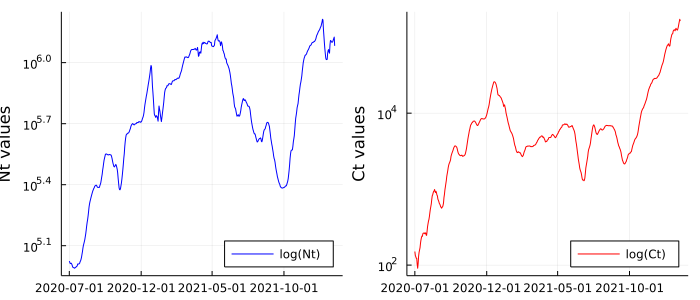

In [3]:
pnt_weekly = @df national_weekly plot(:Date, :Nt, yaxis = :log, ylabel = "Nt values",
    label = "log(Nt)", color = "blue", leg = :bottomright);
pct_weekly = @df national_weekly plot(:Date, :Ct, yaxis = :log, ylabel = "Ct values",
    label = "log(Ct)", color = "red", leg = :bottomright);
plot(pnt_weekly, pct_weekly, layout = (1, 2), size = (700, 300))

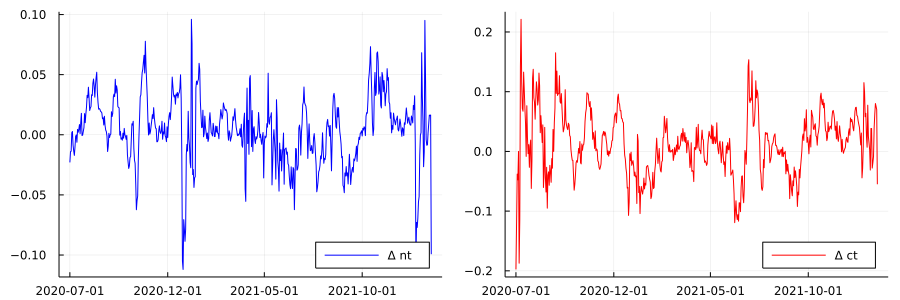

In [18]:
pdnt_weekly = @df national_weekly plot(:Date, :diff_logNt, 
    label = "Δ nt", color = "blue", leg = :bottomright);
pdct_weekly = @df national_weekly plot(:Date, :diff_logCt, 
    label = "Δ ct", color = "red", leg = :bottomright);
plot(pdnt_weekly, pdct_weekly, layout = (1, 2), size = (900, 300))

In [ ]:
ols_national_weekly = lm(@formula(diff_logCt ~ diff_logNt), national_weekly)

In [ ]:
@df national_weekly scatter(:diff_logNt, :diff_logCt, 
    label=:none, aspect_ratio=:equal, xlims = (-0.2, 0.2), ylims = (-0.2, 0.2))
@df national_weekly plot!(:diff_logNt, :diff_logNt * coef(ols_national_weekly)[2], 
                      label = string("(slope = ",round(coef(ols_national_weekly)[2],digits=3), ")"),
                       xlabel = "Δ nt",
                      ylabel = "Δ ct",
                      title = "Weekly")
@df national_weekly hline!([quantile(:diff_logCt, 0.005)], color = :blue, label=:none)
@df national_weekly hline!([quantile(:diff_logCt, 0.995)], color = :blue, label=:none)
@df national_weekly vline!([quantile(:diff_logNt, 0.005)], color = :blue, label=:none)
@df national_weekly vline!([quantile(:diff_logNt, 0.995)], color = :blue, label=:none)

In [ ]:
@df national_weekly scatter(:diff_logNt, :diff_logCt, 
    label=:none, aspect_ratio=:equal, xlims = (-0.2, 0.2), ylims = (-0.22, 0.25))
@df national_weekly plot!(:diff_logNt, :diff_logNt * coef(ols_national_weekly)[2], 
                      label = :none,
                       xlabel = "Δ nt",
                      ylabel = "Δ ct",
                      title = "Slope 0.793")

### Section 1.1.3: Weekday

In [ ]:
pdnt_7dd = @df national_7dd plot(:Date, :Nt, yaxis = :log, ylabel = "Nt values",
    label = "Δ nt", color = "blue", leg = :bottomright);
pdct_7dd = @df national_7dd plot(:Date, :Ct, yaxis = :log, ylabel = "Ct values",
    label = "Δ ct", color = "red", leg = :bottomright);
plot(pdnt_7dd, pdct_7dd, layout = (1, 2), size = (700, 300))

In [ ]:
ols_national_7dd = lm(@formula(diff_logCt ~ diff_logNt), national_7dd)

In [ ]:
@df national_7dd scatter(:diff_logNt, :diff_logCt, label=:none)
@df national_7dd plot!(:diff_logNt, :diff_logNt * coef(ols_national_7dd)[2], 
                      label = string("(slope = ",round(coef(ols_national_7dd)[2],digits=3), ")"),
                       xlabel = "Δ7 nt",
                      ylabel = "Δ7 ct",
                      title = "Weekday")
@df national_7dd hline!([quantile(:diff_logCt, 0.005)], color = :blue, label=:none)
@df national_7dd hline!([quantile(:diff_logCt, 0.995)], color = :blue, label=:none)
@df national_7dd vline!([quantile(:diff_logNt, 0.005)], color = :blue, label=:none)
@df national_7dd vline!([quantile(:diff_logNt, 0.995)], color = :blue, label=:none)

## Section 1.2: Subsample Analysis <a class="anchor" id="subsample"></a>

In this section, we divide the national data into subsamples, and redo the static analysis.

### Section 1.2.1: Daily 

In [ ]:
lm(@formula(diff_logCt ~ 0 + subsample + diff_logNt & subsample), national_daily)

In [ ]:
p = [];
national_daily_subsample = groupby(national_daily, :subsample);
p_i = 0;
for g in national_daily_subsample
    p_i = p_i + 1;
    start_date = g.Date[1];
    ols = lm(@formula(diff_logCt ~ diff_logNt), g);
    pg = @df g scatter(:diff_logNt, :diff_logCt, label=:none)
         @df g plot!(:diff_logNt, :diff_logNt * coef(ols)[2], 
                      label = string("(slope = ",round(coef(ols)[2],digits=3), ")"),
                       xlabel = "Δ nt",
                      ylabel = "Δ ct",
                      title = string("Sample ", p_i, " from ", start_date))
    push!(p, pg)
end
plot(p..., size = (700, 3000), layout = (Int(length(p)), 1))

### Section 1.2.2: Weekly

In [ ]:
lm(@formula(diff_logCt ~ 0 + subsample + diff_logNt & subsample), national_weekly)

In [ ]:
pW = [];
national_weekly_subsample = groupby(national_weekly, :subsample);
p_i = 0;
for g in national_weekly_subsample
    p_i = p_i + 1;
    start_date = g.Date[1];
    ols = lm(@formula(diff_logCt ~ diff_logNt), g);
    pg = @df g scatter(:diff_logNt, :diff_logCt, label=:none)
         @df g plot!(:diff_logNt, :diff_logNt * coef(ols)[2], 
                      label = string("(slope = ",round(coef(ols)[2],digits=3), ")"),
                       xlabel = "Δ nt",
                      ylabel = "Δ ct",
                      title = string("Sample ", p_i, " from ", start_date))
    push!(pW, pg)
end
plot(pW..., size = (700, 3000), layout = (Int(length(p)), 1))

### Section 1.2.3: Weekday

In [ ]:
lm(@formula(diff_logCt ~ 0 + subsample + diff_logNt & subsample), national_7dd)

In [ ]:
p7dd = [];
national_7dd_subsample = groupby(national_7dd, :subsample);
p_i = 0;
for g in national_7dd_subsample
    start_date = g.Date[1];
    p_i = p_i + 1;
    ols = lm(@formula(diff_logCt ~ diff_logNt), g);
    pg = @df g scatter(:diff_logNt, :diff_logCt, label=:none)
         @df g plot!(:diff_logNt, :diff_logNt * coef(ols)[2], 
                      label = string("(slope = ",round(coef(ols)[2],digits=3), ")"),
                       xlabel = "Δ nt",
                      ylabel = "Δ ct",
                      title = string("Sample ", p_i, " from ", start_date))
    push!(p7dd, pg)
end
plot(p7dd..., size = (600, 3000), layout = (Int(length(p)), 1))

## Section 1.3: Autocorrelation Investigation<a class="anchor" id="static_auto"></a>

### Section 1.3.1: Daily

In [ ]:
p1 = plot(bar(autocor(national_daily.diff_logCt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ ct");
p2 = plot(bar(autocor(national_daily.diff_logNt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ nt");
national_daily.ut = national_daily.diff_logCt .- national_daily.diff_logNt * coef(ols_national_daily)[2];
p3 = plot(bar(autocor(national_daily.ut, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of ut");
plot(p1, p2, p3, layout = (1, 3),  ylims = (-0.5, 0.8), size = (900, 400))

### Section 1.3.2: Weekly

In [ ]:
p1 = plot(bar(autocor(national_weekly.diff_logCt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ ct");
p2 = plot(bar(autocor(national_weekly.diff_logNt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ nt");
national_weekly.ut = national_weekly.diff_logCt .- national_weekly.diff_logNt * coef(ols_national_weekly)[2];
p3 = plot(bar(autocor(national_weekly.ut, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of ut");
plot(p1, p2, p3, layout = (1, 3), ylims = (-0.1, 0.85), size = (900, 400))

### Section 1.3.3: Weekday

In [ ]:
p1 = plot(bar(autocor(national_7dd.diff_logCt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ ct");
p2 = plot(bar(autocor(national_7dd.diff_logNt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ nt");
national_7dd.ut = national_7dd.diff_logCt .- national_7dd.diff_logNt * coef(ols_national_7dd)[2];
p3 = plot(bar(autocor(national_7dd.ut, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of ut");
plot(p1, p2, p3, layout = (1, 3), ylims = (-0.1, 0.85), size = (900, 400))

## Section 1.4: Adjusted Case Numbers<a class="anchor" id="static_adjust_case"></a>

For a fixed N,

$$\tilde{C} = C \left( \frac{N}{N_t} \right)^{\hat{\beta}}.$$

### Section 1.4.1: Daily

In [ ]:
national_daily.C_tilde = national_daily.Ct .* (fixN_daily ./ national_daily.Nt) .^ coef(ols_national_daily)[2];
@df filter(:C_tilde => C_tilde -> !isnan(C_tilde), national_daily) plot(:Date, :C_tilde, yaxis = :log, 
    label = "OLS Adjusted log(Ct)", xlabel = "Date", ylabel = "Values of Ct")
@df filter(:C_tilde => C_tilde -> !isnan(C_tilde), national_daily) plot!(:Date, :Ct, yaxis = :log, 
    label = "Observed log(Ct)", leg = :bottomright)

### Section 1.4.2: Weekly

In [ ]:
national_weekly.C_tilde = national_weekly.Ct .* (fixN_weekly ./ national_weekly.Nt) .^ coef(ols_national_weekly)[2];
@df filter(:C_tilde => C_tilde -> !isnan(C_tilde), national_weekly) plot(:Date, :C_tilde, yaxis = :log, 
    label = "OLS Adjusted log(Ct)", xlabel = "Date", ylabel = "Values of Ct")
@df filter(:C_tilde => C_tilde -> !isnan(C_tilde), national_weekly) plot!(:Date, :Ct, yaxis = :log, 
    label = "Observed log(Ct)", leg = :bottomright)

### Section 1.4.3: Weekday

In [ ]:
national_7dd.C_tilde = national_7dd.Ct .* (fixN_7dd ./ national_7dd.Nt) .^ coef(ols_national_7dd)[2];
@df filter(:C_tilde => C_tilde -> !isnan(C_tilde), national_7dd) plot(:Date, :C_tilde, yaxis = :log, 
    label = "OLS Adjusted log(Ct)", xlabel = "Date", ylabel = "Values of Ct")
@df filter(:C_tilde => C_tilde -> !isnan(C_tilde), national_7dd) plot!(:Date, :Ct, yaxis = :log, 
    label = "Observed log(Ct)", leg = :bottomright)

# Section 2: Dynamic Analysis, time-varying $\beta$ <a class="anchor" id="dynamic_analysis"></a>

## Section 2.1: Rolling OLS <a class="anchor" id="dynamic_rolling_ols"></a>

In [5]:
nobs = 60;  # Number of observation in each estimation window, bigger window smoother

roll_beta_national_daily = [];
roll_beta_national_weekly = [];
roll_beta_national_7dd = [];

for i in 1:(N_daily - nobs + 1)
    v = @pipe national_daily[i : i + nobs - 1, :] |>
    lm(@formula(diff_logCt ~ diff_logNt), _) |>
    coef(_)[2] |>
    round(_, digits = 3)
    push!(roll_beta_national_daily, v)
end


for i in 1:(N_weekly - nobs + 1)
    v = @pipe national_weekly[i : i + nobs - 1, :] |>
    lm(@formula(diff_logCt ~ diff_logNt), _) |>
    coef(_)[2] |>
    round(_, digits = 3)
    push!(roll_beta_national_weekly, v)
end

for i in 1:(N_7dd - nobs + 1)
    v = @pipe national_7dd[i : i + nobs - 1, :] |>
    lm(@formula(diff_logCt ~ diff_logNt), _) |>
    coef(_)[2] |>
    round(_, digits = 3)
    push!(roll_beta_national_7dd, v)
end

### Section 2.1.1: Daily 

In [ ]:
plot(national_daily.Date[1:(N_daily - nobs + 1)], roll_beta_national_daily, 
label = :none,
xlabel = "First day of each window",
ylabel = "Rolling OLS \\beta_t")

### Section 2.1.2: Weekly

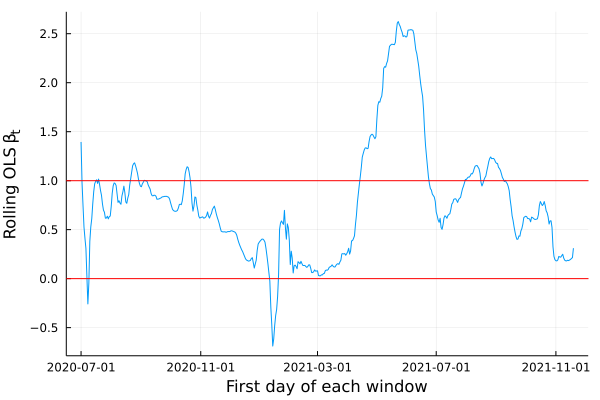

In [17]:
plot(national_weekly.Date[1:(N_weekly - nobs + 1)], roll_beta_national_weekly, 
label = :none,
xlabel = "First day of each window",
ylabel = "Rolling OLS \\beta_t")
hline!([1], label = :none, color = :red)
hline!([0], label = :none, color = :red)

### Section 2.1.3: Weekday

In [ ]:
plot(national_7dd.Date[1:(N_7dd - nobs + 1)], roll_beta_national_7dd, 
label = :none,
xlabel = "First day of each window",
ylabel = "Rolling OLS \\beta_t")

## Section 2.2: First score model

If we assume $\beta_t$ and $\log (\pi^*_t)$ are locally constant, the model can be simplified to,

$$
\Delta c_t = 
\beta_t
\Delta n_t +
U_t
$$

Assume a constant $\sigma$ for the new error term for now to simplify further...

Simplify notation, $y_t = \Delta c_t$ and $x_t = \Delta n_t$.

The log-likelihood is:

$$\ell(\beta_t) \propto - T \log(\sigma^2) - \sum_{t=1}^T \frac{(y_t - \beta_t x_t)^2}{\sigma^2};$$

The score is:

$$\frac{\partial \ell}{\partial \beta_t} = \frac{1}{\sigma^2} (y_t - \beta_t x_t) x_t;$$

The hessian is:

$$\frac{\partial^2 \ell}{\partial \beta_t^2} = - \frac{1}{\sigma^2} x_t^2;$$

Define
$$\psi(\beta_t) =
\frac{\frac{\partial \ell}{\partial \beta_t}}{\sqrt{- \frac{\partial^2 \ell}{\partial \beta_t^2}}}
=
\frac{\frac{1}{\sigma^2} (y_t - \beta_t x_t) x_t}{\sqrt{\frac{1}{\sigma^2} x_t^2}}
= 
\frac{1}{\sigma} \text{sign}(x_t) (y_t - \beta_t x_t)
$$

The model is (new version):

$$\beta_{t+1} = \omega + \phi \beta_t + \alpha \psi(\beta_t)
=
\omega + \phi \beta_t + \alpha \frac{\text{sign}(x_t) (y_t - \beta_t x_t)}{\sigma} 
$$

In [3]:
using Optim;
function ScoreBeta(θ, data)
    x = data.diff_logNt;
    y = data.diff_logCt;
    T = nrow(data);
    ω = θ[1]; 
    ϕ = θ[2];
    α = θ[3]; 
    σ = θ[4];
    θ0 = θ[5];
    β0 = 1/(1 + exp(-θ0));
    β = [];  
    # Checked by CS people, this step is totally fine, wouldn't make any difference to memory or speed.
    # During optimazition process, this beta will be cleared after every update.
    push!(β, β0)  
    
    for i in 1:(T-1)
        v = ω + ϕ * β[i] + α * sign(x[i]) * (y[i] - β[i] * x[i]) / σ
        push!(β, v)
    end

    
    return β
end

function logL(θ, data)
    x = data.diff_logNt;
    y = data.diff_logCt;
    T = nrow(data);
    β = ScoreBeta(θ, data);
    σ = θ[4];
    sum((y .- β .* x).^2)/(σ^2) + T*log(σ^2)   # Note: This is negative logL, not logL.
end

logL (generic function with 1 method)

## Second Score Model

Assume normal errors, $\Delta \log \hat{C_t^*} \sim N(0, \sigma^2)$. 

Simplify notation, $y_t = \Delta \log C_t$ and $x_t = \Delta \log N_t$.

To ensure $\beta$ is between 0 to 1, re-parameterize it as $$\beta_t = \frac{1}{1 + \exp(-\theta_t)}.$$

The log-likelihood is:

$$
\ell(\theta_t) \propto - T \log(\sigma^2) 
- 
\frac{1}{\sigma^2} 
\sum_{t=1}^T \left(y_t - \frac{x_t}{1 + \exp(-\theta_t)}\right)^2
;$$

The score is:

$$
\frac{\partial \ell}{\partial \theta_t} 
= 
\frac{x_t}{\sigma^2  \exp(\theta_t) \left( 1 + \exp(-\theta_t) \right)^2}
\left(  y_t - \frac{x_t}{1 + \exp(-\theta_t)}  \right) 
;$$

The wrong hessian is (didn't take expectation):

$$
\frac{\partial^2 \ell}{\partial \theta_t^2} 
= 
\frac{x_t}{\sigma^2  \exp(\theta_t) (1 + \exp(-\theta_t))^2}
\left(
\frac{2 y_t}{\exp(\theta_t)  (1 + \exp(-\theta_t))}
-
y_t
-
\frac{3 x_t}{\exp(\theta_t) (1 + \exp(-\theta_t))^2}
+
\frac{x_t}{1 + \exp(-\theta_t)}
\right)
;$$

The right hessian is:
$$
\frac{\partial^2 \ell}{\partial \theta_t^2} 
=
- \frac{x_t^2}{\sigma^2   \exp(2 \theta_t)   (1 + \exp(-\theta_t))^4}
$$

Define
$$
\psi(\theta_t) =
\frac{\frac{\partial \ell}{\partial \theta_t}}{\sqrt{- \frac{\partial^2 \ell}{\partial \theta_t^2}}}
=
\frac{1}{\sigma} \text{sign}(x_t) \left(y_t -  \frac{x_t}{1 + \exp(-\theta_t)} \right)
,$$

The model is (new version):

$$
\theta_{t+1} = \omega + \phi \theta_t + \alpha \psi(\theta_t)
.$$

In [19]:
using Optim;
function logL(θstatic, data)    # Note: This function returns negative logL, not logL.
    x = data.diff_logNt;
    y = data.diff_logCt;
    T = nrow(data);
    ω = θstatic[1]; 
    ϕ = θstatic[2];
    α = θstatic[3]; 
    σ = θstatic[4];
    θ0 = θstatic[5];
    θ = [];
    push!(θ, θ0);
    
    for i in 1:(T-1)
        #score = x[i] / (σ^2 * exp(θ[i]) * (1 + exp(-θ[i]))^2) * (y[i] - x[i] / (1 + exp(-θ[i])));
        newθ = ω + ϕ * θ[i] + α *  sign(x[i]) * (y[i] - x[i] / (1 + exp(-θ[i]))) / σ;
        push!(θ, newθ); 
    end
    
    ll = T * log(σ^2) + sum( ( y .- x ./ ( 1 .+ exp.(-θ) ) ).^2 ) / (σ^2);
    return ll     
end

logL (generic function with 1 method)

Coding notes: 

Checked by CS people, this function is totally fine, no efficiency issues. No is any memory wasted at all. The vector $\beta$ is just a middle product, so $\beta$ will not be kept anywhere in the system but will be destroyed after implementing the function because logL does not return $\beta$.

Even if the function is implemented many times during optimization, there is always at most only one $\beta$ in the system. On the other hand, if a global $\beta$ is created outside the function and then get updated, it will always be kept in the system, i.e. always takes some memory, though the space taken is small.

The two chunks below are just to show that even if the function logL is called and successfully operated, the middle-product variable $\beta$ will not be kept, but rather be dropped. 

In [ ]:
logL([0, 0.1, 0.1, 0.2, 0.6, 1], national_weekly)

In [ ]:
β

In [20]:
function recoverBeta(θstatic, data)
    x = data.diff_logNt;
    y = data.diff_logCt;
    T = nrow(data);
    ω = θstatic[1]; 
    ϕ = θstatic[2];
    α = θstatic[3]; 
    σ = θstatic[4];
    θ0 = θstatic[5];
    θ = [];
    push!(θ, θ0);
    
    for i in 1:(T-1)
        #score = x[i] / (σ^2 * exp(θ[i]) * (1 + exp(-θ[i]))^2) * (y[i] - x[i] / (1 + exp(-θ[i])));
        newθ = ω + ϕ * θ[i] + α *  sign(x[i]) * (y[i] - x[i] / (1 + exp(-θ[i]))) / σ;
        push!(θ, newθ); 
    end
    
    β = 1 ./ (1 .+ exp.(-θ));
    return(β)
end

recoverBeta (generic function with 1 method)

### Section 2.2.1: Daily

In [ ]:
θ_national_daily = [0, 1, 0.5, 0.9, 0];
obj_national_daily = θ_national_daily -> logL(θ_national_daily, national_daily) 
res_national_daily = optimize(obj_national_daily, θ_national_daily)
Optim.minimizer(res_national_daily)  # Estimated static parameters

In [ ]:
ScoreBetaHat_national_daily = recoverBeta(Optim.minimizer(res_national_daily), national_daily);
plot(national_daily.Date, ScoreBetaHat_national_daily, 
label = :none,
xlabel = "Date",
ylabel = "Score \\beta_t")

### Section 2.2.2: Weekly

In [23]:
# different initial values result in different results 
# θ_national_weekly = [0, 1, 0.1, 0.2, 0];
θ_national_weekly = [0, 0.1, 0.1, 0.9, 0];
obj_national_weekly = θ_national_weekly -> logL(θ_national_weekly, national_weekly) 
res_national_weekly = optimize(obj_national_weekly, θ_national_weekly)
Optim.minimizer(res_national_weekly)  # Estimated parameters

5-element Vector{Float64}:
  -0.09508529687255218
   0.5023472824956535
   3.6034078012953845
   0.04350331072804711
 197.96279628881777

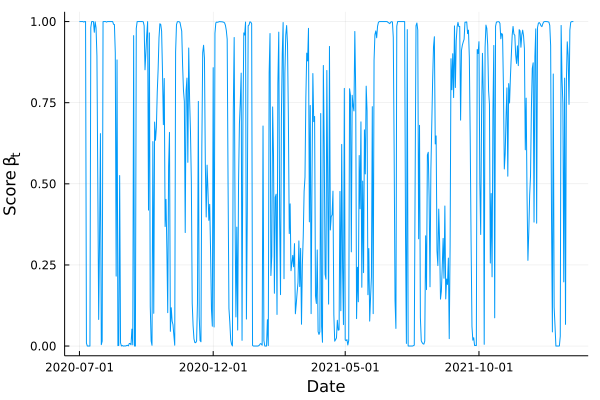

In [24]:
ScoreBetaHat_national_weekly = recoverBeta(Optim.minimizer(res_national_weekly), national_weekly);
plot(national_weekly.Date, ScoreBetaHat_national_weekly, 
label = :none,
xlabel = "Date",
ylabel = "Score \\beta_t")

### Section 2.2.3: Weekday

In [ ]:
# θ_national_7dd = [0, 1, 0, 0.2, 0.6];
θ_national_7dd = [0, 1, 0.5, 0.2, 0.6];
obj_national_7dd = θ_national_7dd -> logL(θ_national_7dd, national_7dd) 
res_national_7dd = optimize(obj_national_7dd, θ_national_7dd)
Optim.minimizer(res_national_7dd)  # Estimated parameters

In [ ]:
ScoreBetaHat_national_7dd = recoverBeta(Optim.minimizer(res_national_7dd), national_7dd);
plot(national_7dd.Date, ScoreBetaHat_national_7dd, 
label = :none,
xlabel = "Date",
ylabel = "Score \\beta_t")

## Section 2.3: Score Out-of-sample Forecast<a class="anchor" id="dynamic_out_sample"></a>

The name "step" in my code means the sample size of data kept for out-of-sample forecast.

If step = 10, I estimate $\beta$ for 10 times. The first time, I use all data but the last 10 for estimation, and then make one out-of-sample forecast for the last 10th observation; The second time, I use all data but the last 9 for estimation, and only make one step ahead forecast for the last 9th observation; ... Repeat until I have all out-of-sample forecast for the 10 observations.

The graph shows observed $\Delta log C_t$ in blue and predicted in red. 

### Section 2.3.1: Daily

In [ ]:
# moved to old file
# to be added

### Section 2.3.2: Weekly

In [ ]:
# moved to old file
# to be added

### Section 2.3.3: Weekday

In [ ]:
# moved to old file
# to be added

## Section 2.4: Score Adjusted Case Numbers<a class="anchor" id="dynamic_adjust_case"></a>

$$\tilde{C} = C \left( \frac{N}{N_t} \right)^{\hat{\beta_t}}$$

### Section 2.4.1: Daily

In [ ]:
national_daily.ScoreBetaHat = ScoreBetaHat_national_daily;
national_daily.C_tilde_score = national_daily.Ct .* (fixN_daily ./ national_daily.Nt) .^ national_daily.ScoreBetaHat;

@df filter(:C_tilde_score => C_tilde -> !isnan(C_tilde), national_daily) plot(:Date, :C_tilde_score, yaxis = :log, 
    label = "Score Adjusted log(Ct)", xlabel = "Date", ylabel = "Ct values")
@df filter(:C_tilde_score => C_tilde -> !isnan(C_tilde), national_daily) plot!(:Date, :Ct, yaxis = :log, 
    label = "Observed log(Ct)", leg = :bottomright)

### Section 2.4.2: Weekly

In [ ]:
national_weekly.ScoreBetaHat = ScoreBetaHat_national_weekly;
national_weekly.C_tilde_score = national_weekly.Ct .* (fixN_weekly ./ national_weekly.Nt) .^ national_weekly.ScoreBetaHat;

@df filter(:C_tilde_score => C_tilde -> !isnan(C_tilde), national_weekly) plot(:Date, :C_tilde_score, yaxis = :log, 
    label = "Score Adjusted log(Ct)", xlabel = "Date", ylabel = "Ct values")
@df filter(:C_tilde_score => C_tilde -> !isnan(C_tilde), national_weekly) plot!(:Date, :Ct, yaxis = :log, 
    label = "Observed log(Ct)", leg = :bottomright)

### Section 2.4.3: Weekday

In [ ]:
national_7dd.ScoreBetaHat = ScoreBetaHat_national_7dd;
national_7dd.C_tilde_score = national_7dd.Ct .* (fixN_7dd ./ national_7dd.Nt) .^ national_7dd.ScoreBetaHat;

@df filter(:C_tilde_score => C_tilde -> !isnan(C_tilde), national_7dd) plot(:Date, :C_tilde_score, yaxis = :log, 
    label = "Score Adjusted", xlabel = "Date", ylabel = "log(Ct)")
@df filter(:C_tilde_score => C_tilde -> !isnan(C_tilde), national_7dd) plot!(:Date, :Ct, yaxis = :log, 
    label = "Observed", leg = :bottomright)

## Section 2.5: Autocorrelation Investigation<a class="anchor" id="dynamic_auto"></a>

### Section 2.5.1:Daily

In [ ]:
p1 = plot(bar(autocor(national_daily.diff_logCt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ ct");
p2 = plot(bar(autocor(national_daily.diff_logNt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ nt");
national_daily.ut = national_daily.diff_logCt .- national_daily.diff_logNt .* national_daily.ScoreBetaHat;
p3 = plot(bar(autocor(national_daily.ut, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of ut");
plot(p1, p2, p3, layout = (1, 3), ylims = (-0.5, 0.8), size = (900, 400))

### Section 2.5.2: Weekly

In [ ]:
p1 = plot(bar(autocor(national_weekly.diff_logCt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ ct");
p2 = plot(bar(autocor(national_weekly.diff_logNt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ nt");
national_weekly.ut = national_weekly.diff_logCt .- national_weekly.diff_logNt .* national_weekly.ScoreBetaHat;
p3 = plot(bar(autocor(national_weekly.ut, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of ut");
plot(p1, p2, p3, layout = (1, 3), ylims = (-0.2, 0.85), size = (900, 400))

### Section 2.5.3: Weekday

In [ ]:
p1 = plot(bar(autocor(national_daily.diff_logCt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ ct");
p2 = plot(bar(autocor(national_daily.diff_logNt, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of Δ nt");
national_daily.ut = national_daily.diff_logCt .- national_daily.diff_logNt .* national_daily.ScoreBetaHat;
p3 = plot(bar(autocor(national_daily.ut, 1:30),  label = :none), 
    xlabel = "lag", title = "ACF of ut");
plot(p1, p2, p3, layout = (1, 3), ylims = (-0.2, 0.85), size = (900, 400))

# Section 3: Municipality Data Analysis, Panel Data<a class="anchor" id="muni_analysis"></a>

In [ ]:
# Remove Municipalities with too few Nt (< 100 on average)
drop_cities = ["Christiansø", "Ærø", "Fanø", "Samsø", "Læsø", "NA"]

muni_Ct = @pipe CSV.File("Municipality_Ct.csv") |>
DataFrame |>
rename!(_, :SampleDate => :Date) |>
select(_, Not(drop_cities));
muni_Nt = @pipe CSV.File("Municipality_Nt.csv") |> 
DataFrame |>
rename!(_, :PrDate_adjusted => :Date) |>
select(_, Not(drop_cities));
muni_daily_level = @pipe innerjoin(muni_Ct, muni_Nt, on = :Date, makeunique=true);
## Notes: The orders of the columns in the two files are different.



# create daily data for model
df1 = @pipe muni_daily_level |>
transform(_, names(_, Not(:Date)) .=> (x -> log.(x)); renamecols=false);
for col in eachcol(df1)
    replace!(col, -Inf => 0)  # When initial numbers are 0, replace log of it to be 0 instead of -inf.
end
muni_daily = @pipe df1 |> 
transform(_, names(_, Not(:Date)) .=> (x -> x - lag(x)); renamecols=false)|>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs));

# create weekly data for model
muni_weekly_level = mapcols!(v -> runmean(v, windowsize) * windowsize, muni_daily_level[:, Not(:Date)]);
insertcols!(muni_weekly_level, 1, :Date => muni_daily_level.Date);
delete!(muni_weekly_level, 1: (windowsize - 1));
df2 = @pipe muni_weekly_level |>
transform(_, names(_, Not(:Date)) .=> (x -> log.(x)); renamecols=false);
for col in eachcol(df2)
    replace!(col, -Inf => 0)  # When initial numbers are 0, replace log of it to be 0 instead of -inf.
end
muni_weekly = @pipe df2 |> 
transform(_, names(_, Not(:Date)) .=> (x -> x - lag(x)); renamecols=false)|>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs));

# create weekday data for model
muni_7dd = @pipe df1 |> 
transform(_, names(_, Not(:Date)) .=> (x -> x - lag(x, 7)); renamecols=false)|>
subset(_, :Date => ByRow(D -> D >= date_of_first_obs));

## Section 3.1: Static Analysis<a class="anchor" id="muni_static_analysis"></a>

### Section 3.1.1: Daily

In [ ]:
ols_muni_daily_coef = DataFrame(City = [], OlS_Intercept = [], OLS_Slope = Float64[], OLS_Slope_sd = []);
for i in 1 : Int((ncol(muni_daily)-1)/2)
    diff_logCt = muni_daily[:, i + 1]
    # to match Ct and Nt for the same city ---->
    city_name = names(muni_daily)[i + 1]  
    diff_logNt = muni_daily[:, string(city_name, "_1")]
    data = DataFrame(diff_logCt = diff_logCt, diff_logNt = diff_logNt)
    OLS = lm(@formula(diff_logCt ~ diff_logNt), data)
    coef_w_name = @pipe round.(coef(OLS), digits = 4) |> 
    vcat(_, round.(stderror(OLS)[2], digits = 4)) |>
    vcat([city_name], _)
    push!(ols_muni_daily_coef, coef_w_name);
end
ols_muni_daily_coef

### Section 3.1.2: Weekly

In [ ]:
ols_muni_weekly_coef = DataFrame(City = [], OlS_Intercept = [], OLS_Slope = Float64[], OLS_Slope_sd = []);
for i in 1 : Int((ncol(muni_weekly)-1)/2)
    diff_logCt = muni_weekly[:, i + 1]
    # to match Ct and Nt for the same city ---->
    city_name = names(muni_weekly)[i + 1]  
    diff_logNt = muni_weekly[:, string(city_name, "_1")]
    data = DataFrame(diff_logCt = diff_logCt, diff_logNt = diff_logNt)
    OLS = lm(@formula(diff_logCt ~ diff_logNt), data)
    coef_w_name = @pipe round.(coef(OLS), digits = 4) |> 
    vcat(_, round.(stderror(OLS)[2], digits = 4)) |>
    vcat([city_name], _)
    push!(ols_muni_weekly_coef, coef_w_name);
end
ols_muni_weekly_coef

### Section 3.1.3: Weekday

In [ ]:
ols_muni_7dd_coef = DataFrame(City = [], OlS_Intercept = [], OLS_Slope = Float64[], OLS_Slope_sd = []);
for i in 1 : Int((ncol(muni_7dd)-1)/2)
    diff_logCt = muni_7dd[:, i + 1]
    # to match Ct and Nt for the same city ---->
    city_name = names(muni_7dd)[i + 1]  
    diff_logNt = muni_7dd[:, string(city_name, "_1")]
    data = DataFrame(diff_logCt = diff_logCt, diff_logNt = diff_logNt)
    OLS = lm(@formula(diff_logCt ~ diff_logNt), data)
    coef_w_name = @pipe round.(coef(OLS), digits = 4) |> 
    vcat(_, round.(stderror(OLS)[2], digits = 4)) |>
    vcat([city_name], _)
    push!(ols_muni_7dd_coef, coef_w_name);
end
ols_muni_7dd_coef

## Section 3.2: Dynamic Analysis<a class="anchor" id="muni_dynamic_analysis"></a>


In [ ]:
# restricted model moved to old file
# First restrict the intercept and slope in the socre equation to be 0 and 1 respectively.
# The $\beta_0$ is also part of the parameters now.

### Section 3.2.1: Daily

In [ ]:
muni_daily_score_coef = DataFrame(City = String[], 
    ω = String[], ϕ = String[], α = String[], σ = String[], θ0 = String[]);
muni_daily_score_beta = DataFrame();
θ = [0, 1, 1, 0.2, 0.6];
for i in 1 : Int((ncol(muni_daily)-1)/2)
    diff_logCt = muni_daily[:, i + 1]
    # to match Ct and Nt for the same city ---->
    city_name = names(muni_daily)[i + 1]  
    diff_logNt = muni_daily[:, string(city_name, "_1")]
    data = DataFrame(diff_logCt = diff_logCt, diff_logNt = diff_logNt)
    obj = θ -> logL(θ, data);
    res = optimize(obj, θ);
    coef_w_name = @pipe Optim.minimizer(res) |> round.(_, digits = 4) |> string.(_) |> append!([city_name],  _);
    push!(muni_daily_score_coef, coef_w_name);
    muni_daily_score_beta[!, city_name] = recoverBeta(Optim.minimizer(res), data);
end
insertcols!(muni_daily_score_beta, 1, :Date => muni_daily.Date);

In [ ]:
muni_daily_score_coef

In [ ]:
muni_daily_score_beta

### Section 3.2.2: Weekly

In [ ]:
muni_weekly_score_coef = DataFrame(City = String[], 
    ω = String[], ϕ = String[], α = String[], σ = String[], θ0 = String[]);
muni_weekly_score_beta = DataFrame();
θ = [0, 1, 1, 0.2, 0.6];
for i in 1 : Int((ncol(muni_weekly)-1)/2)
    diff_logCt = muni_weekly[:, i + 1]
    # to match Ct and Nt for the same city ---->
    city_name = names(muni_weekly)[i + 1]  
    diff_logNt = muni_weekly[:, string(city_name, "_1")]
    data = DataFrame(diff_logCt = diff_logCt, diff_logNt = diff_logNt)
    obj = θ -> logL(θ, data);
    res = optimize(obj, θ);
    coef_w_name = @pipe Optim.minimizer(res) |> round.(_, digits = 4) |> string.(_) |> append!([city_name],  _);
    push!(muni_weekly_score_coef, coef_w_name);
    muni_weekly_score_beta[!, city_name] = recoverBeta(Optim.minimizer(res), data);
end
insertcols!(muni_weekly_score_beta, 1, :Date => muni_weekly.Date);

In [ ]:
muni_weekly_score_coef

In [ ]:
muni_weekly_score_beta

### Section 3.2.3: Weekday

In [ ]:
muni_7dd_score_coef = DataFrame(City = String[], 
    ω = String[], ϕ = String[], α = String[], σ = String[], θ0 = String[]);
muni_7dd_score_beta = DataFrame();
θ = [0, 1, 1, 0.2, 0.6];
for i in 1 : Int((ncol(muni_7dd)-1)/2)
    diff_logCt = muni_7dd[:, i + 1]
    # to match Ct and Nt for the same city ---->
    city_name = names(muni_7dd)[i + 1]  
    diff_logNt = muni_7dd[:, string(city_name, "_1")]
    data = DataFrame(diff_logCt = diff_logCt, diff_logNt = diff_logNt)
    obj = θ -> logL(θ, data);
    res = optimize(obj, θ);
    coef_w_name = @pipe Optim.minimizer(res) |> round.(_, digits = 4) |> string.(_) |> append!([city_name],  _);
    push!(muni_7dd_score_coef, coef_w_name);
    muni_7dd_score_beta[!, city_name] = recoverBeta(Optim.minimizer(res), data);
end
insertcols!(muni_7dd_score_beta, 1, :Date => muni_7dd.Date);

In [ ]:
muni_7dd_score_coef

In [ ]:
muni_7dd_score_beta

## Section 3.3: Explore Correlation between $\beta$ and Data <a class="anchor" id="beta_and_data"></a>

### Section 3.3.1: Daily

In [ ]:
# Calculate positive-ratio for each municipality, panel data
muni_daily_PosRatio = DataFrame(); 
for i in 1 : Int((ncol(muni_daily_level)-1)/2)
    Ct = muni_daily_level[:, i+1];
    city_name = names(muni_daily_level)[i + 1];
    Nt = muni_daily_level[:, string(city_name, "_1")];
    ratio = Ct ./ Nt;
    muni_daily_PosRatio[!, city_name] = ratio;
end
insertcols!(muni_daily_PosRatio, 1, :Date => muni_daily_level.Date);
for col in eachcol(muni_daily_PosRatio)
    replace!(col, NaN => 0, Inf => 0);  # When Nt are 0, replace the ratio to be 0 instead of NaN and Inf.
end

# Create a dataframe contain averaged Nt and PosRatio and OLS estimates, cross-sectional data
d1 = @pipe DataFrame(City = names(muni_Nt, Not(:Date)),
          AveNt = mean.(eachcol(muni_Nt[:, Not(:Date)]))); 
d2 = @pipe DataFrame(City = names(muni_daily_PosRatio, Not(:Date)),
          AveRatio = Float64.(mean.(eachcol(muni_daily_PosRatio[:, Not(:Date)]))));
ols_nt_ratio_muni_daily = @pipe leftjoin(ols_muni_daily_coef, d1, on = :City) |> 
leftjoin(_, d2, on = :City);

#### Cross-sectional
The x-axis in plot below is averaged $N_t$ over time for all cities, and y-aix is the city's corresponding $\beta$ estimates. I expect there is negative relationship between the two, but the plot shows the opposite.

Cross-sectional OLS:

$\beta_i = a_0 + a_1 \bar{r}_i + a_2 \log(\bar{N}_i) + e_i$,

where $i$ is each municipality, 
$\bar{r}_i$ is averaged positive ratio over time for municipality $i$,
$\bar{N}_i$ is averaged $N_t$ over time for municipality $i$.

In [ ]:
@df ols_nt_ratio_muni_daily scatter(log.(:AveNt), :OLS_Slope, 
    label = :none, 
    xlabel = "log(Ni)", 
    ylabel = "OLS \\beta", title = "Each point is a municipality")

In [ ]:
@df ols_nt_ratio_muni_daily scatter(:AveRatio, :OLS_Slope, 
    label = :none, 
    xlabel = "Average Positive Ratio", 
    ylabel = "OLS \\beta", title = "Each point is a municipality")

In [ ]:
ols_muni_daily_beta_ratio_cross_sectional = lm(@formula(OLS_Slope ~ AveRatio + log(AveNt)), 
    ols_nt_ratio_muni_daily)

In [ ]:
ols_nt_ratio_muni_daily.cs_ols_res = residuals(ols_muni_daily_beta_ratio_cross_sectional);
@df filter(:AveNt => v -> v <= 2000, ols_nt_ratio_muni_daily) scatter(log.(:AveNt), :cs_ols_res,
    label = :none, 
    xlabel = "log(Ni)", 
    ylabel = "Cross-sectional OLS residuals", title = "Each point is a municipality");

#### Time-series

In [ ]:
Aarhus = @pipe innerjoin(select(muni_Nt, :Date, "Aarhus" => "Nt"), 
    select(muni_daily_score_beta, :Date, "Aarhus" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Aarhus" => "Ct"), 
    on = :Date => :Date);
Aarhus.PosRatio = Aarhus.Ct ./ Aarhus.Nt;
@df Aarhus plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Aarhus", color = "blue", leg = :bottomright)
@df Aarhus plot!(twinx(), :Date, log.(:Nt), label = "log(Nt)", 
    color = "red", leg = :topright)

In [ ]:
@df Aarhus scatter(log.(:Nt), :ScoreBetaHat, label = :none, 
    title = "Aarhus", xlabel = "log(Nt)", ylabel = "Score beta hat")

In [ ]:
Aalborg = @pipe innerjoin(select(muni_Nt, :Date, "Aalborg" => "Nt"), 
    select(muni_daily_score_beta, :Date, "Aalborg" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Aalborg" => "Ct"), 
    on = :Date => :Date);
Aalborg.PosRatio = Aalborg.Ct ./ Aalborg.Nt;
@df Aalborg plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Aalborg", color = "blue", leg = :bottomright)
@df Aalborg plot!(twinx(), :Date, log.(:Nt), label = "log(Nt)", 
    color = "red", leg = :topright)

In [ ]:
@df Aalborg scatter(log.(:Nt), :ScoreBetaHat, label = :none, 
    title = "Aalborg", xlabel = "log(Nt)", ylabel = "Score beta hat")

In [ ]:
Odense = @pipe innerjoin(select(muni_Nt, :Date, "Odense" => "Nt"), 
    select(muni_daily_score_beta, :Date, "Odense" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Odense" => "Ct"), 
    on = :Date => :Date);
Odense.PosRatio = Odense.Ct ./ Odense.Nt;
@df Odense plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Odense", color = "blue", leg = :bottomright)
@df Odense plot!(twinx(), :Date, :Nt, label = "Nt", 
    color = "red", leg = :topright)

In [ ]:
@df Odense scatter(:Nt, :ScoreBetaHat, label = :none, 
    title = "Odense", xlabel = "Nt", ylabel = "Score beta hat")

In [ ]:
Copenhagen = @pipe innerjoin(select(muni_Nt, :Date, "Copenhagen" => "Nt"), 
    select(muni_daily_score_beta, :Date, "Copenhagen" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Copenhagen" => "Ct"), 
    on = :Date => :Date);
Copenhagen.PosRatio = Copenhagen.Ct ./ Copenhagen.Nt;
@df Copenhagen plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Copenhagen", color = "blue", leg = :bottomright)
@df Copenhagen plot!(twinx(), :Date, :Nt, label = "Nt", 
    color = "red", leg = :topright)

In [ ]:
@df Copenhagen scatter(:Nt, :ScoreBetaHat, label = :none, 
    title = "Copenhagen", xlabel = "Nt", ylabel = "Score beta hat")

### Section 3.3.2: Weekly

#### Cross-sectional

In [ ]:
# Calculate positive-ratio for each municipality, panel data
muni_weekly_PosRatio = DataFrame(); 
for i in 1 : Int((ncol(muni_weekly_level)-1)/2)
    Ct = muni_weekly_level[:, i+1];
    city_name = names(muni_weekly_level)[i + 1];
    Nt = muni_weekly_level[:, string(city_name, "_1")];
    ratio = Ct ./ Nt;
    muni_weekly_PosRatio[!, city_name] = ratio;
end
insertcols!(muni_weekly_PosRatio, 1, :Date => muni_weekly_level.Date);
for col in eachcol(muni_weekly_PosRatio)
    replace!(col, NaN => 0, Inf => 0);  # When Nt are 0, replace the ratio to be 0 instead of NaN and Inf.
end

# Create a dataframe contain averaged Nt and PosRatio and OLS estimates, cross-sectional data
d1 = @pipe DataFrame(City = names(muni_Nt, Not(:Date)),
          AveNt = mean.(eachcol(muni_Nt[:, Not(:Date)]))); 
d2 = @pipe DataFrame(City = names(muni_weekly_PosRatio, Not(:Date)),
          AveRatio = Float64.(mean.(eachcol(muni_weekly_PosRatio[:, Not(:Date)]))));
ols_nt_ratio_muni_weekly = @pipe leftjoin(ols_muni_weekly_coef, d1, on = :City) |> 
leftjoin(_, d2, on = :City);

In [ ]:
@df ols_nt_ratio_muni_weekly scatter(log.(:AveNt), :OLS_Slope, 
    label = :none, 
    xlabel = "log(Ni)", 
    ylabel = "OLS \\beta", title = "Each point is a municipality")

In [ ]:
@df ols_nt_ratio_muni_weekly scatter(:AveRatio, :OLS_Slope, 
    label = :none, 
    xlabel = "Average Positive Ratio", 
    ylabel = "OLS \\beta", title = "Each point is a municipality")

In [ ]:
ols_muni_weekly_beta_ratio_cross_sectional = lm(@formula(OLS_Slope ~ AveRatio + log(AveNt)), 
    ols_nt_ratio_muni_weekly)

### Section 3.3.3: Weekday

#### Cross-sectional

In [ ]:
ols_nt_ratio_muni_7dd = @pipe leftjoin(ols_muni_7dd_coef, d1, on = :City) |> 
leftjoin(_, d2, on = :City);

In [ ]:
@df ols_nt_ratio_muni_7dd scatter(log.(:AveNt), :OLS_Slope, 
    label = :none, 
    xlabel = "log(Ni)", 
    ylabel = "OLS \\beta", title = "Each point is a municipality")

In [ ]:
@df ols_nt_ratio_muni_7dd scatter(:AveRatio, :OLS_Slope, 
    label = :none, 
    xlabel = "Average Positive Ratio", 
    ylabel = "OLS \\beta", title = "Each point is a municipality")

In [ ]:
ols_muni_7dd_beta_ratio_cross_sectional = lm(@formula(OLS_Slope ~ AveRatio + log(AveNt)), 
    ols_nt_ratio_muni_7dd)

#### Time-series

In [ ]:
Aarhus_7dd = @pipe innerjoin(select(muni_Nt, :Date, "Aarhus" => "Nt"), 
    select(muni_7dd_score_beta, :Date, "Aarhus" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Aarhus" => "Ct"), 
    on = :Date => :Date);
Aarhus_7dd.PosRatio = Aarhus_7dd.Ct ./ Aarhus_7dd.Nt;
@df Aarhus_7dd plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Aarhus 7dd", color = "blue", leg = :bottomright)
@df Aarhus_7dd plot!(twinx(), :Date, log.(:Nt), label = "log(Nt)", 
    color = "red", leg = :topright)

In [ ]:
@df Aarhus_7dd scatter(log.(:Nt), :ScoreBetaHat, label = :none, 
    title = "Aarhus 7dd", xlabel = "log(Nt)", ylabel = "Score beta hat")

In [ ]:
Aalborg_7dd = @pipe innerjoin(select(muni_Nt, :Date, "Aalborg" => "Nt"), 
    select(muni_7dd_score_beta, :Date, "Aalborg" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Aalborg" => "Ct"), 
    on = :Date => :Date);
Aalborg_7dd.PosRatio = Aalborg_7dd.Ct ./ Aalborg_7dd.Nt;
@df Aalborg_7dd plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Aalborg 7dd", color = "blue", leg = :bottomright)
@df Aalborg_7dd plot!(twinx(), :Date, log.(:Nt), label = "log(Nt)", 
    color = "red", leg = :topright)

In [ ]:
@df Aalborg_7dd scatter(:Nt, :ScoreBetaHat, label = :none, 
    title = "Aalborg 7dd", xlabel = "Nt", ylabel = "Score beta hat")

In [ ]:
Odense_7dd = @pipe innerjoin(select(muni_Nt, :Date, "Odense" => "Nt"), 
    select(muni_7dd_score_beta, :Date, "Odense" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Odense" => "Ct"), 
    on = :Date => :Date);
Odense_7dd.PosRatio = Odense_7dd.Ct ./ Odense_7dd.Nt;
@df Odense_7dd plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Odense 7dd", color = "blue", leg = :bottomright)
@df Odense_7dd plot!(twinx(), :Date, :Nt, label = "Nt", 
    color = "red", leg = :topright)

In [ ]:
@df Odense_7dd scatter(:Nt, :ScoreBetaHat, label = :none, 
    title = "Odense 7dd", xlabel = "Nt", ylabel = "Score beta hat")

In [ ]:
Copenhagen_7dd = @pipe innerjoin(select(muni_Nt, :Date, "Copenhagen" => "Nt"), 
    select(muni_7dd_score_beta, :Date, "Copenhagen" => "ScoreBetaHat"), 
    on = :Date => :Date) |> innerjoin(_, 
    select(muni_Ct, "Date" => "Date", "Copenhagen" => "Ct"), 
    on = :Date => :Date);
Copenhagen_7dd.PosRatio = Copenhagen_7dd.Ct ./ Copenhagen_7dd.Nt;
@df Copenhagen_7dd plot(:Date, :ScoreBetaHat, label = "β hat", 
    title = "Copenhagen 7dd", color = "blue", leg = :bottomright)
@df Copenhagen_7dd plot!(twinx(), :Date, :Nt, label = "Nt", 
    color = "red", leg = :topright)

In [ ]:
@df Copenhagen_7dd scatter(:Nt, :ScoreBetaHat, label = :none, 
    title = "Copenhagen 7dd", xlabel = "Nt", ylabel = "Score beta hat")